### **下載資料**

In [334]:
tr_path = 'covid.train.csv'  # 訓練資料的路徑
tt_path = 'covid.test.csv'  # 測試資料的路徑
# google drive的連結
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 28.7MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 21.6MB/s]


### **安裝相關套件**

In [335]:
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Sklearn
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import preprocessing

# 資料預處理
import numpy as np
import pandas as pd
import csv
import os

# 畫圖
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# 設定隨機種子(確保輸出模型一致)
myseed = 42069
# 參考資料:https://zhuanlan.zhihu.com/p/583387718
# CPU版本的PyTorch只要所有參數初始化一樣,超參數也一樣則輸出的model會一樣
# GPU版本的PyTorch在訓練時可能會引入額外的隨機源,導致輸出的模型不一致
# torch.backends.cudnn.deterministic = True可以讓輸出結果一致
torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark決定是否要在開始執行程式時先尋找整個網路最適合每個卷積層的卷積方法
# 固定的網路結構與輸入形狀(batch size、圖片大小、輸入通道等)，可以透過開啟這個功能實現網路加速(True)
# 反之，不斷變動的卷積層會不斷花費時間在最佳化上，因此會花費更多時間
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)


### **設定會用到的功能函式**

In [336]:
# 判斷是GPU還是CPU
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 5.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of your DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

### **選擇特徵**

In [337]:
# 讀取訓練資料
data = pd.read_csv(r'covid.train.csv')
# 設定特徵
x = data[data.columns[1:94]]
# 設定目標
y = data[data.columns[94]]

# 特徵標準化
x = (x - x.min()) / (x.max() - x.min())

# 用f_regression方法計算特徵的分數(與目標的關聯性)
bestfeatures = SelectKBest(score_func=f_regression)

# 計算所有特徵的分數
fit = bestfeatures.fit(x,y)

# 將分數轉換成DataFrame形式
dfscores = pd.DataFrame(fit.scores_)

# 將訓練資料的欄位名字做成DataFrame形式
dfcolumns = pd.DataFrame(x.columns)

# 將兩個DataFrame連結在一起
featurescores = pd.concat([dfcolumns,dfscores],axis=1)

# 替featurescores的欄位命名
featurescores.columns = ['Feats','Score']

# 印出分數前20高的特徵
print(featurescores.nlargest(20,'Score'))

# 將分數前14高的index存起來(之後要用到的特徵index)
top_rows = featurescores.nlargest(20, 'Score').index.tolist()[:14]
print(top_rows)

                 Feats          Score
75   tested_positive.1  148069.658278
57     tested_positive   69603.872591
42        hh_cmnty_cli    9235.492094
60      hh_cmnty_cli.1    9209.019558
78      hh_cmnty_cli.2    9097.375172
43      nohh_cmnty_cli    8395.421300
61    nohh_cmnty_cli.1    8343.255927
79    nohh_cmnty_cli.2    8208.176435
40                 cli    6388.906849
58               cli.1    6374.548000
76               cli.2    6250.008702
41                 ili    5998.922880
59               ili.1    5937.588576
77               ili.2    5796.947672
92  worried_finances.2     833.613191
74  worried_finances.1     811.916460
56    worried_finances     788.076931
87    public_transit.2     686.736539
69    public_transit.1     681.562902
51      public_transit     678.834789
[75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]


### **資料前處理**

*   讀取`.csv`檔
*   提取特徵與目標
*   將`train.csv`的資料分成train與dev資料
*   將資料標準化

  
  

In [338]:
class COVID19Dataset(Dataset):
    ''' Dataset for loading and preprocessing the COVID19 dataset '''
    def __init__(self,
                 path,
                 mode='train',
                 target_only=False):
        self.mode = mode

        # Read data into numpy arrays
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            # data[1:]將第2行列以後的數據取出來
            # [:, 1:]將前面取出的數據，其第2行以後的數據取出來
            data = np.array(data[1:])[:, 1:].astype(float)

        if not target_only:
            feats = list(range(93))
        else:
            # TODO: Using 40 states & 2 tested_positive features (indices = 57 & 75)
            # 選擇關聯性較高的資料加進特徵裡面
            # 參考網址:https://blog.csdn.net/haerxiluo/article/details/126280677
            feats = [75, 57, 42, 60, 78, 43, 61, 79, 40, 58, 76, 41, 59, 77]

        if mode == 'test':
            # Testing data
            # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            data = data[:, feats]
            # 將資料從numpy轉成tensor
            self.data = torch.FloatTensor(data)
        else:
            # Training data (train/dev sets)
            # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
            # data[:, -1] 讀取所有列的最後一行數據
            target = data[:, -1]
            data = data[:, feats]

            # Splitting training data into train & dev sets
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]

            # Convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])

        # Normalize features (you may remove this part to see what will happen)
        # mean(dim=0, keepdim=True)) 是針對第0維取平均，keepdim=True 代表取完平均後自動下降1個維度
        # std(dim=0, keepdim=True) 是針對第0維取標準差，keepdim=True 代表取完平均後自動下降1個維度
        # 做完資料標準化後，所有資料的均值為0，標準差為1
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]

        print('Finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
              .format(mode, len(self.data), self.dim))

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'dev']:
            # For training
            return self.data[index], self.target[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        # Returns the size of the dataset
        return len(self.data)

### **DataLoader**
透過DataLoader從Dataset載入資料

In [339]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)  # Construct dataset
    # drop_last:當資料數不能被batch_size整除時，是否丟掉不能整除的資料
    # pin_memory:是否將資料放到GPU上
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=False,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

### **Deep Neural Network**


In [340]:
class NeuralNet(nn.Module):
  def __init__(self, input_dim):
    # super(NeuralNet, self).__init__()是指調用父類別的初始化，這邊的父類別為nn.Module
    super(NeuralNet, self).__init__()

    # 定義自己的網路
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 16),
        nn.ReLU(),
        nn.Linear(16, 8),
        nn.ReLU(),
        nn.Linear(8, 1),
    )

    # 定義損失函數(Mean Squared Error)
    self.criterion = nn.MSELoss(reduction='mean')

  # 計算預測結果並去掉維度數維1的維度
  def forward(self, x):
    return self.net(x).squeeze(1)

  # 計算loss
  # 用 L2 regularization 替模型增加限制，避免模型 over-fitting(降低模型準確度但增加泛用姓)
  # 參考資料:https://allen108108.github.io/blog/2019/10/22/L1%20,%20L2%20Regularization%20%E5%88%B0%E5%BA%95%E6%AD%A3%E5%89%87%E5%8C%96%E4%BA%86%E4%BB%80%E9%BA%BC%20_/
  def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # TODO: you may implement L1/L2 regularization here
        loss_sum = 0
        for p in model.parameters():
            loss_sum += torch.sum(p ** 2)
        # loss_sum 的係數可以自行調整
        return torch.sqrt(self.criterion(pred, target)) + 0.0001 * loss_sum

### **Training**

In [341]:
def train(tr_set, dv_set, model, config, device):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    # getattr(object, name[, default]) 是返回object的屬性(name)的值，等於object.name
    # 這裡是用於設定最佳化方法(config['optimizer'])，並將超參數(**config['optim_hparas'])代入最佳化方法裡
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:                       # 參考資料:https://zhuanlan.zhihu.com/p/357075502
        model.train()                          # 設定成訓練模式(啟用batch normalization跟dropout)
        for x, y in tr_set:                     # 透過dataloader進行迭代
            optimizer.zero_grad()                  # 將gradient設為0(避免梯度累積)
            x, y = x.to(device), y.to(device)          # 將資料移到設備裡(cpu/cuda)
            pred = model(x)                    # 計算輸出(forward pass)
            mse_loss = model.cal_loss(pred, y)          # 計算loss
            mse_loss.backward()                   # 計算gradient(backpropagation)
            optimizer.step()                    # 更新參數
            loss_record['train'].append(mse_loss.detach().cpu().item()) # 紀錄training loss

        # 在每次epoch後用驗證資料集測試訓練後的模型
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # 如果loss變小，將現在的loss存成最小loss並儲存模型
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'
                .format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1                  # 如果loss變大則把early_stop_cnt+1

        epoch += 1
        loss_record['dev'].append(dev_mse)
        # 當early_stop_cnt大於設定的值則停止訓練模型
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record

### **Validation**

In [342]:
def dev(dv_set, model, device):
    model.eval()                              # 將模型設成evalutation模式
    total_loss = 0
    for x, y in dv_set:                         # 透過dataloader進行迭代
        x, y = x.to(device), y.to(device)              # 將資料移到設備裡(cpu/cuda)
        with torch.no_grad():                     # 關掉梯度計算
            pred = model(x)                    # 計算輸出(forward pass)
            mse_loss = model.cal_loss(pred, y)          # 計算loss
        total_loss += mse_loss.detach().cpu().item() * len(x)    # 累加loss(mse_loss.detach().cpu().item()是只讀取loss信息)
    total_loss = total_loss / len(dv_set.dataset)            # 計算平均loss

    return total_loss

### **Testing**

In [343]:
def test(tt_set, model, device):
    model.eval()                              # 將模型設成evalutation模式
    preds = []
    for x in tt_set:                           # 透過dataloader進行迭代
        x = x.to(device)                       # 將資料移到設備裡(cpu/cuda)
        with torch.no_grad():                     # 關掉梯度計算
            pred = model(x)                    # 計算輸出(forward pass)
            preds.append(pred.detach().cpu())            # 儲存預測結果
    preds = torch.cat(preds, dim=0).numpy()               # 將預測結果整合成一個numpy array
    return preds

### Hyper-**parameters**
設置訓練時的超參數

In [344]:
device = get_device()                  # 取得現在使用的設備(CPU/Cuda)
os.makedirs('models', exist_ok=True)           # 創造'models'目錄(exist_ok=True代表已存在目錄的情況下不會觸發FileExistsError)
target_only = True                   # TODO: Using 40 states & 2 tested_positive features

# TODO: How to tune these hyper-parameters to improve your model's performance?
config = {
    'n_epochs': 10000,                # maximum number of epochs
    'batch_size': 64,                # mini-batch size for dataloader
    'optimizer': 'Adam',               # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,              # learning rate of SGD
        # 'momentum': 0.9             # momentum for SGD
    },
    'early_stop': 1000,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'         # your model will be saved here
}

### **載入資料與模型**

In [345]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

model = NeuralNet(tr_set.dataset.dim).to(device)  # Construct model and move to device

Finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 14)
Finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 14)
Finished reading the test set of COVID19 Dataset (893 samples found, each dim = 14)


### **開始訓練**

In [346]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 8.2825)
Saving model (epoch =    2, loss = 3.1315)
Saving model (epoch =    3, loss = 2.7930)
Saving model (epoch =    4, loss = 2.4405)
Saving model (epoch =    5, loss = 1.9392)
Saving model (epoch =    6, loss = 1.3315)
Saving model (epoch =    7, loss = 1.2117)
Saving model (epoch =    8, loss = 1.1443)
Saving model (epoch =    9, loss = 1.0816)
Saving model (epoch =   14, loss = 1.0527)
Saving model (epoch =   16, loss = 1.0454)
Saving model (epoch =   17, loss = 1.0412)
Saving model (epoch =   19, loss = 1.0330)
Saving model (epoch =   25, loss = 1.0188)
Saving model (epoch =   27, loss = 1.0070)
Saving model (epoch =   29, loss = 0.9997)
Saving model (epoch =   31, loss = 0.9927)
Saving model (epoch =   39, loss = 0.9701)
Saving model (epoch =   40, loss = 0.9652)
Saving model (epoch =   43, loss = 0.9579)
Saving model (epoch =   47, loss = 0.9510)
Saving model (epoch =   53, loss = 0.9416)
Saving model (epoch =   59, loss = 0.9278)
Saving mode

### **畫出結果**

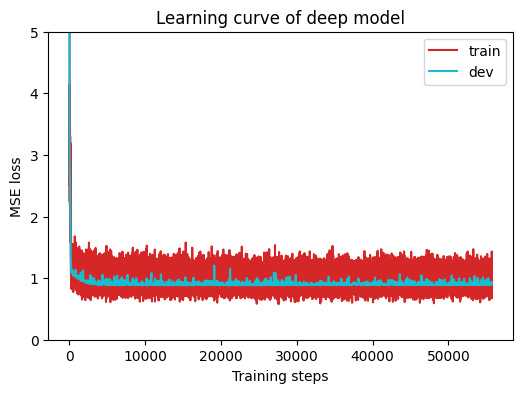

In [347]:
plot_learning_curve(model_loss_record, title='deep model')

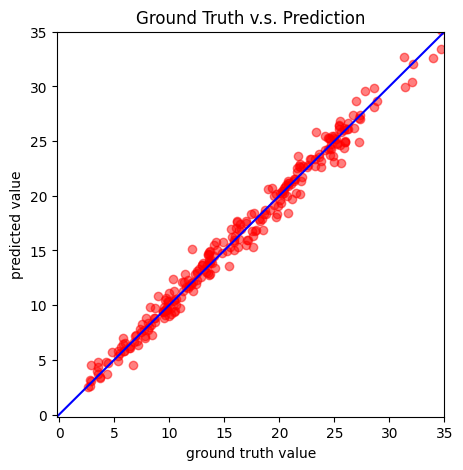

In [348]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
ckpt = torch.load(config['save_path'], map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # Show prediction on the validation set

### **測試**
模型在測試資料集的預測結果會存成`.csv`檔

In [349]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    print('Saving results to {}'.format(file))
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

Saving results to pred.csv
